In [1]:
# get_ipython().magic('matplotlib notebook')
get_ipython().magic('matplotlib inline')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
xr.set_options(keep_attrs=True)

/home/ollie/pscholz/tripyview_github


In [2]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= 5
which_mode= 'ghflx' # global heat flux

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_jayne_bin_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'ghflx'
year      = [1979,2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None # 'TKE, ck=0.1' # None
ref_year  = None # [2009,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = 0
crange, cmin, cmax, cfac, climit = None, None, None, None, None

#_____________________________________________________________________________________
which_dpi = 300
do_allcycl= False

In [3]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if which_cycl is not None: 
    #__________________________________________________________________________________________________
    if do_allcycl: cycl_s=1
    else         : cycl_s=which_cycl    
    
    #__________________________________________________________________________________________________
    aux_path, aux_name = list(), list()
    input_paths_old, input_names_old = input_paths, input_names
    for ii, (ipath,iname) in enumerate(zip(input_paths,input_names)):
        for ii_cycl in range(cycl_s, which_cycl+1):
            # input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
            aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(iname))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
            print(ii, aux_path[-1],aux_name[-1])
    input_paths, input_names = aux_path, aux_name
    
    #__________________________________________________________________________________________________
    if ref_path is not None:
        aux_path, aux_name = list(), list()
        ref_path_old, ref_name_old = ref_path, ref_name
        for ii_cycl in range(cycl_s, which_cycl+1):
            #ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
            aux_path.append(os.path.join(ref_path,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(ref_name))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, ref_name))
            print('R', ref_path[-1])        
        ref_path, ref_name = aux_path, aux_name
    del(aux_path, aux_name)    
        
#______________________________________________________________________________________________________        
cinfo=dict({'cstr':cstr, 'cnum':cnum}) 
if crange   is not None: cinfo['crange']=crange
if cmin     is not None: cinfo['cmin'  ]=cmin
if cmax     is not None: cinfo['cmax'  ]=cmax
if cref     is not None: cinfo['cref'  ]=cref
if cfac     is not None: cinfo['cfac'  ]=cfac  
if climit   is not None: cinfo['climit']=climit     
if ref_path is not None: cinfo['cref'  ]=0.0    
    
#______________________________________________________________________________________________________
# in case of diff plots
if ref_path is not None:
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record   
        
#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if ref_path is not None: 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths, ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names        

 > found *.pckl file: /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node.pckl
 > comp. e_resol from mean
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________
0 /home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/5/ TKE


In [4]:
n_area  = None
datapath = input_paths[0]
#___________________________________________________________________________
# Load triangle and cluster area if not given 
if n_area is None: #or e_area is None:
    #if do_info==True: print(' --> load triangle and cluster area from diag .nc file')
    fname = 'fesom.mesh.diag.nc'
    # check for directory with diagnostic file
    if   os.path.isfile( os.path.join(datapath, fname) ): 
        dname = datapath
    elif os.path.isfile( os.path.join( os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/'), fname) ): 
        dname = os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/')
    elif os.path.isfile( os.path.join(mesh.path,fname) ): 
        dname = mesh.path
    else:
        raise ValueError('could not find directory with...mesh.diag.nc file')    
        
    # load diag file
    meshdiag = xr.open_dataset(os.path.join(dname,fname))
        
    # only need cluster area from the surface since density classes dont know 
    # any information aboutthe bottom 
    if n_area is None: n_area = meshdiag['nod_area'].isel(nz=0) 
    #if e_area is None: e_area = meshdiag['elem_area']

In [5]:
data_list = list()
#___LOAD FESOM2 DATA___________________________________________________________________________________    
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    data  = tpv.load_data_fesom2(mesh, datapath, vname='fh', year=year, descript=descript , do_info=False)
    attrs_g=data.attrs
    data  = data*n_area
    data  = data.assign_attrs(attrs_g)
    data  = data.assign_coords({'node_A':("nod2",n_area.data)})
    data_list.append( data ) # , n_area, e_area) )

/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/5/ TKE


In [6]:
#___________________________________________________________________________
# create meridional bins
# if do_info==True: print(' --> create latitudinal bins')
dlat      = 1.0
n_y       = mesh.n_y.copy()
lat       = np.arange(np.floor(n_y.min())-dlat, np.ceil(n_y.max())+dlat, dlat)
lat_i     = (( n_y-lat[0])/dlat ).astype('int')    
nlat      = lat.size
list_dimname, list_dimsize = ['nlat'], [nlat]

ghflx_list = list()
for data in data_list:
    #___________________________________________________________________________
    # Create xarray dataset
    data_vars = dict()
    aux_attr  = data['fh'].attrs
    aux_attr['long_name'], aux_attr['units'] = 'Global Heat Transport', 'PW'
    data_vars['ghflx'] = (list_dimname, np.zeros(list_dimsize), aux_attr) 
    # define coordinates
    coords    = {'nlat' : (['nlat' ], lat )}
    # create dataset
    ghflx     = xr.Dataset(data_vars=data_vars, coords=coords, attrs=data.attrs)
    del(data_vars, coords, aux_attr)

    #___________________________________________________________________________
    # do zonal sum over latitudinal bins 
    for bini in range(lat_i.min(), lat_i.max()):
        # sum over latitudinal bins
        ghflx['ghflx'].data[bini] = data['fh' ].isel(nod2=lat_i==bini).sum(dim='nod2')

    #___________________________________________________________________________    
    # do cumulative sum over latitudes    
    ghflx['ghflx'] = -ghflx['ghflx'].cumsum(dim='nlat', skipna=True)*1.0e-15    
    
    #___________________________________________________________________________    
    ghflx_list.append(ghflx)
    del(ghflx)

<IPython.core.display.Javascript object>


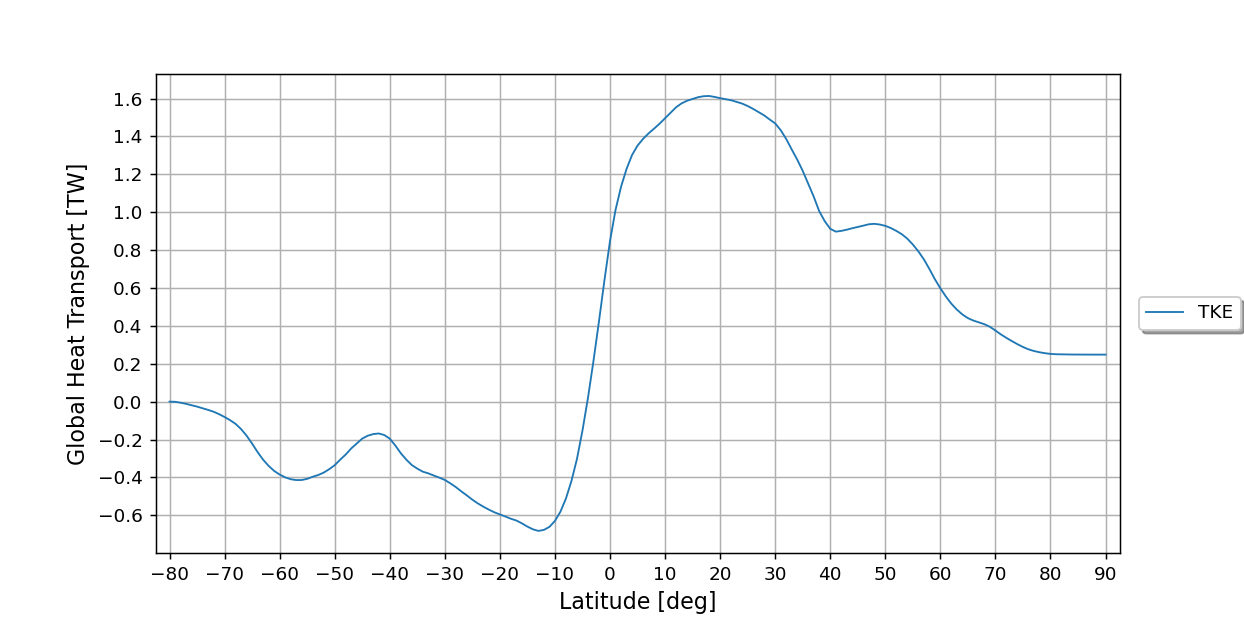

In [8]:
# #___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = list(ghflx_list[0].keys())[0]
slabel = ghflx_list[0]['ghflx'].attrs['str_lsave']
if spath is not None: spath  = os.path.join(spath,'{}_{}_{}.png'.format(which_mode, sname, slabel)) 
if save_fname is not None: spath = save_fname

#____________________________________________________________________________________________________
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
figsize=[7,3.5]
fig,ax= plt.figure(figsize=figsize),plt.gca()
    
#___________________________________________________________________________
# setup colormap
cmap = tpv.categorical_cmap(len(ghflx_list), 1, cmap="tab10")
    
#___________________________________________________________________________
for ii_ts, (data, data_name) in enumerate(zip(ghflx_list, input_names)):
    #___________________________________________________________________________
    data_x, data_y = data['nlat'].values, data['ghflx'].values
    hp=ax.plot(data_x, data_y, 
               linewidth=1, label=data_name, color=cmap.colors[ii_ts,:], 
               marker='None', markerfacecolor='w', markersize=5, 
               zorder=2)
                 
#___________________________________________________________________________
ax.legend(shadow=True, fancybox=True, frameon=True, bbox_to_anchor=(1.02,0.5), loc="center left", borderaxespad=0)
ax.set_xlabel('Latitude [deg]',fontsize=12)
ax.set_ylabel('Global Heat Transport [TW]', fontsize=12)
    
#___________________________________________________________________________
xmaxstep, ymaxstep = 10, 0.2
xmajor_locator = MultipleLocator(base=xmaxstep) # this locator puts ticks at regular intervals
ymajor_locator = MultipleLocator(base=ymaxstep) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(xmajor_locator)
ax.yaxis.set_major_locator(ymajor_locator)

xminor_locator = AutoMinorLocator(xmaxstep/10)
yminor_locator = AutoMinorLocator(ymaxstep/5)
ax.yaxis.set_minor_locator(yminor_locator)
ax.xaxis.set_minor_locator(xminor_locator)
    
plt.grid(which='major')
plt.xlim(data_x[0]-(data_x[-1]-data_x[0])*0.015,data_x[-1]+(data_x[-1]-data_x[0])*0.015)    
    
#___________________________________________________________________________
plt.show()
fig.canvas.draw()
    
#___________________________________________________________________________
# save figure based on do_save contains either None or pathname
tpv.do_savefigure(spath, fig, dpi=which_dpi)